# Study -- ellipse

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os


In [2]:
PATH_BASE = os.getcwd()
#print("PATH_BASE = ", PATH_BASE)

os.chdir( "../../figs")
PATH_FIGS = os.getcwd()
#print("PATH_FIGS = ", PATH_FIGS )

os.chdir( PATH_BASE )
os.chdir( "../libs")
PATH_LIBS = os.getcwd()
#print("PATH_LIBS = ", PATH_LIBS )

# re-set path back to base
os.chdir( PATH_BASE )
#print("Currently in: ", os.getcwd() )


In [3]:
# Libraries created by MZ
os.chdir( PATH_LIBS )

import plotting as pg
import costgrad_vec as cg
import common as nc
import algos_vec as ao
import params as pm
import common_vec as cv

os.chdir( PATH_BASE )


# Parameters

In [4]:
size_title = 25
size_label = 20

g_a = 4
g_b = 1


# Basic GD

In [5]:
nom = cg.get_cost_names()
print(nom)
name = nom[2]
print("name = ", name)

p_init = cg.get_p_init(name)
print("p_init = ", p_init)

p_target = cg.get_p_target(name)
print("p_target = ", p_target)

# parameters ----------------------------
num      = 100
b_print  = True
rho_targ = 0.1

# Increase alpha by a factor of i_factor at i = i_manual.  To skip this, set i<0
i_manual = -1
i_factor = 1

#g_rho_type = "original"
g_rho_type = "new"

# Definition of rho --------------
print("g_rho_type = ", g_rho_type)

# for sumd plot ---------------
g_sumd_line_freq = 10

type_opt = "dp_GD_basic"
#type_opt = "dp_GD_momentum"
#type_opt = "dp_GD_Nesterov"
#type_opt = "dp_RMSProp"
#type_opt = "dp_Adam"
print("algorithm = ", type_opt)


['x^2', 'x^4', 'ellipse', '1Dsigwell', '2Dshell', 'Beale']
name =  ellipse
p_init =  [4. 1.]
p_target =  [0. 0.]
g_rho_type =  new
algorithm =  dp_GD_basic


In [6]:
alpha    = 0.1 #GD
#alpha    = 0.5  # RMSProp
d_res_GD_1 = ao.do_GDFamily(name, alpha, num, p_init.copy(), p_target, type_opt, rho_targ, b_print, i_manual, i_factor, g_rho_type)


cost_old =  2.0
1: cost,rho,dotp = 1.3605297119140627, 0.09184845075720732, 0.9985237532230046
2: cost,rho,dotp = 1.1894490518836978, 0.08812055333055636, 0.9979122836984196
3: cost,rho,dotp = 1.072039477000962, 0.08302587180446125, 0.9971457551600681
4: cost,rho,dotp = 0.9891761082442194, 0.0763767084205355, 0.9962732439613982
5: cost,rho,dotp = 0.9286141359850271, 0.06820167502029226, 0.9954160484351486
6: cost,rho,dotp = 0.8825121164193491, 0.058857371828182015, 0.9947586820878948
7: cost,rho,dotp = 0.8458468782671839, 0.049026475769466664, 0.9944849903433559
8: cost,rho,dotp = 0.8153990601189154, 0.03954595474263674, 0.9946820718329661
9: cost,rho,dotp = 0.7891038514686426, 0.031140589043380035, 0.9952865893911198
10: cost,rho,dotp = 0.7656354641784346, 0.024226160273738417, 0.996124277488408
11: cost,rho,dotp = 0.7441411914878701, 0.01888020114406735, 0.9970047679261599
12: cost,rho,dotp = 0.7240712031203189, 0.014941720661764775, 0.9977942215463476
13: cost,rho,dotp = 0.705069611

max index =  100
final arclength (sumd_x) =  3.444096758756803
final distance (sumd_y) =  3.0325929073792977


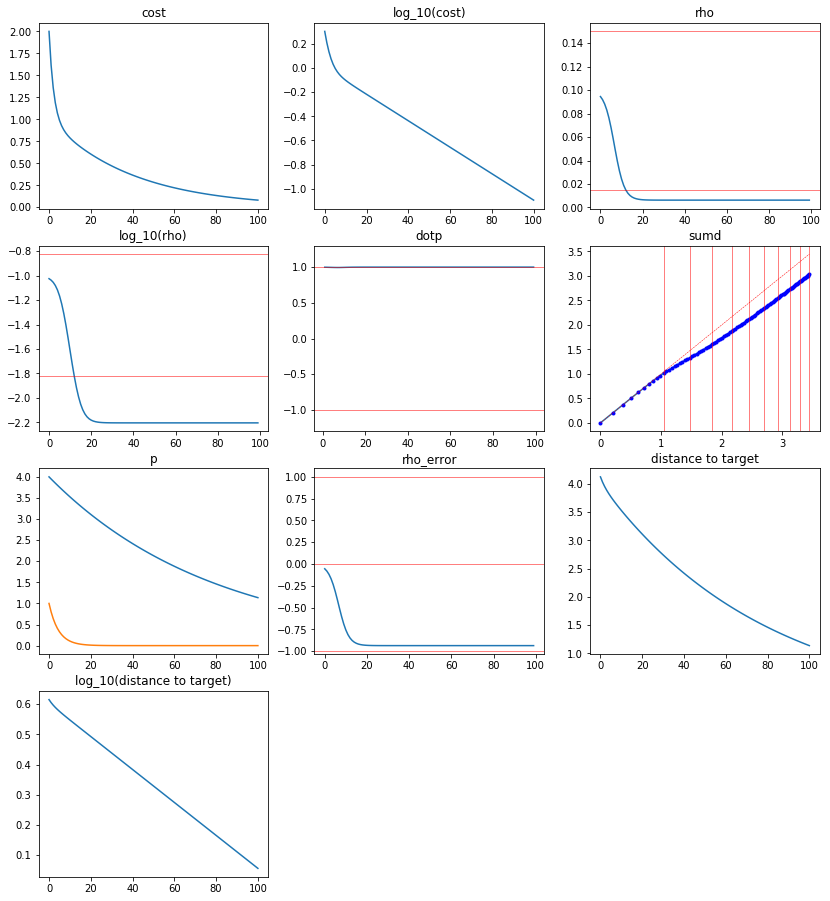

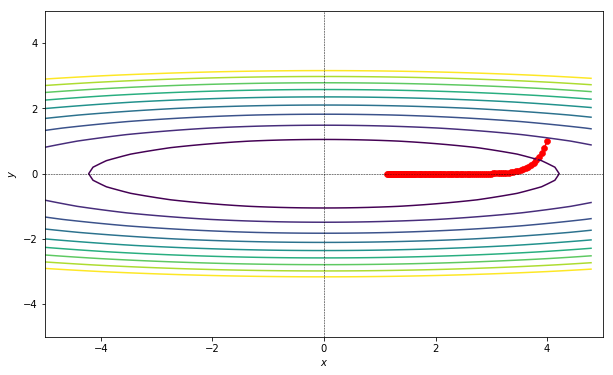

In [7]:
pg.do_Plots_final(d_res_GD_1, pm.g_rhomin, pm.g_rhomax, g_sumd_line_freq )
pg.do_plot_special(name, d_res_GD_1)
#filename = None
#pg.do_plot_2Dshell_special(name, d_res_GD_1, "2Dshell", filename, pm.g_ymin_2Dshell, pm.g_ymax_2Dshell)


# Ideal GD

### (adapted from library algos_vec.py)

In [8]:
def get_Qm( p, m ):
    p1 = p[0]
    p2 = p[1]
    Qm = (p1**2)/g_a**m + (p2**2)/g_b**m
    return( Qm )

def get_alpha_original(p, rho_):
    Q4 = get_Qm( p, 4)
    Q6 = get_Qm( p, 6)
    res = (Q4/Q6)*( rho_/(rho_ +1) )
    return( res )

def get_alpha(p, rho_):
    Q4 = get_Qm( p, 4)
    Q6 = get_Qm( p, 6)
    res = (Q4/Q6)* rho_
    return( res )


In [9]:
#=========================================================================
def do_GDFamily_ideal_ellipse(name, alpha, num, p_old, p_target, type_opt, rho_targ, b_print, g_rho_type ):  
    v     = np.zeros(p_old.shape, dtype=np.float128)
    v2    = np.zeros(p_old.shape, dtype=np.float128)

    # init ---------------------------
    p_ref     = p_old.copy()  #a copy of initial p, to compute sumd_y
    cost_old  = cg.get_cost(name, p_old)
    print("cost_old = ", cost_old)
    dp_old    = None
    dist      = cv.get_dist(p_old, p_target)
    d_res     = nc.init_results( ["cost","rho","dotp","sumd_x","sumd_y","p","rho_error","dist"] )
    nc.update_results( d_res, {"p":p_old.copy(), "cost":cost_old, "sumd_x":0.0, "sumd_y":0.0, "dist":dist} )
    sumd_x   = 0
    
    for i in range(num):
        # grad -------------------------
        grad      = cg.get_grad(name, p_old)
        
        # new part ---------------------
        alpha = get_alpha(p_old, rho_targ)
        print("alpha = ", alpha)

        # optimize ---------------------
        dp,v,v2   = ao.get_dp_choice(type_opt, grad, p_old, v, v2, i, alpha)
        
        # cost -------------------------
        p_new     = cv.get_p_new(p_old, dp)
        cost_new  = cg.get_cost(name, p_new)

        # diagnostics ------------------
        est_diff  = cv.get_est_diff(grad, dp)
        rho       = nc.get_rho(cost_old, cost_new, est_diff, g_rho_type)
        rho_error = nc.get_rho_error( rho, rho_targ )
        dotp      = cv.get_dotp_2(dp_old, dp)
        sumd_x   += cv.get_sumd_x(dp)  #a running total
        sumd_y    = cv.get_sumd_y(p_ref, p_new)  #a point measurement

        # updates ----------------------
        p_old    = p_new.copy()
        cost_old = cost_new
        dp_old   = dp.copy()
        dist     = cv.get_dist(p_old, p_target)
        nc.update_results(d_res, {"rho":rho, "p":p_old.copy(), "cost":cost_old, "dotp":dotp, "sumd_x":sumd_x, "sumd_y":sumd_y, "rho_error":rho_error, "dist":dist} )

        # printout ---------------------
        if(b_print):
            nc.do_printout(d_res, i, nfreq=1)
    
    return(d_res)


In [10]:
alpha    = 0.1
d_res_GD_2 = do_GDFamily_ideal_ellipse(name, alpha, num, p_init.copy(), p_target, type_opt, rho_targ, b_print, g_rho_type )


cost_old =  2.0
alpha =  0.1058365758754864
alpha =  0.10912474961700612
1: cost,rho,dotp = 1.3271276901970424, 0.0999999999999997, 0.9983010585341682
alpha =  0.11447417773624975
2: cost,rho,dotp = 1.1462114342561796, 0.10000000000000032, 0.9973535382684903
alpha =  0.12351031884063127
3: cost,rho,dotp = 1.0202360369992092, 0.0999999999999992, 0.9958267072536764
alpha =  0.13975333978812163
4: cost,rho,dotp = 0.9277717590840668, 0.1, 0.9932883465717222
alpha =  0.17228075345247465
5: cost,rho,dotp = 0.8531670155148152, 0.09999999999999866, 0.9888514183387173
alpha =  0.25207952508821413
6: cost,rho,dotp = 0.7804877563861536, 0.09999999999999712, 0.9804340076982897
alpha =  0.5513711757325687
7: cost,rho,dotp = 0.6705996409219193, 0.10000000000000137, 0.9622171945270142
alpha =  1.5587341838032553
8: cost,rho,dotp = 0.43502036523734655, 0.0999999999999997, 0.9186726969066262
alpha =  1.3545449846303326
9: cost,rho,dotp = 0.3009193026308157, 0.09999999999999941, 0.9884463564435305
alpha

max index =  100
final arclength (sumd_x) =  4.6549631636276025
final distance (sumd_y) =  4.123078438750359


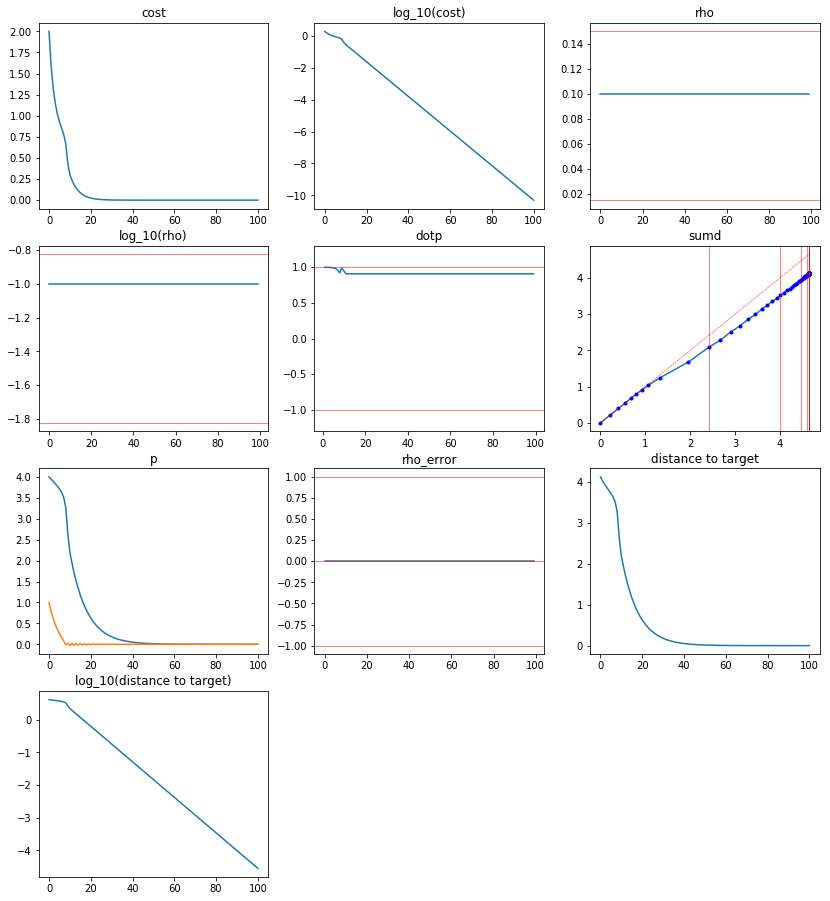

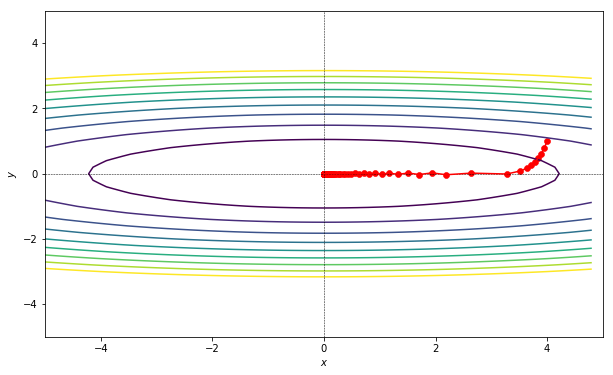

In [11]:
pg.do_Plots_final(d_res_GD_2, pm.g_rhomin, pm.g_rhomax, g_sumd_line_freq )
pg.do_plot_special(name, d_res_GD_2)
#filename = None
#pg.do_plot_2Dshell_special(name, d_res_GD_2, "2Dshell", filename, pm.g_ymin_2Dshell, pm.g_ymax_2Dshell)


## Comparison plot

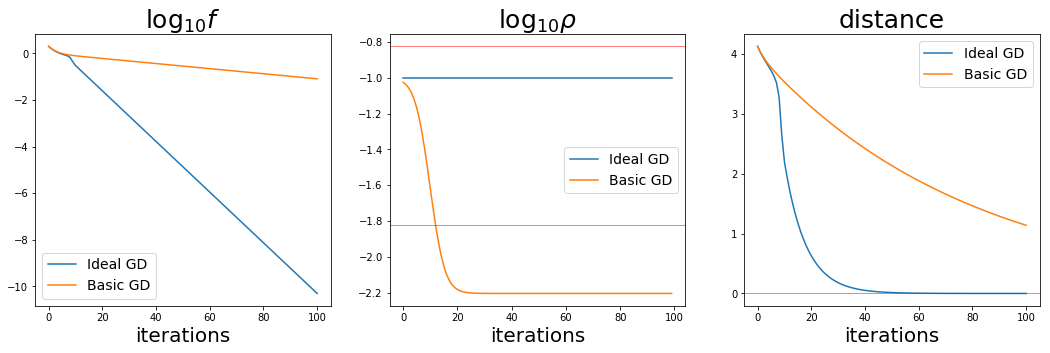

In [12]:
nrows = 1
ncols = 3
plt.figure(1, figsize=(6*ncols, 5*nrows))

idx = 1
# log(cost) --------------------------------
plt.subplot(nrows, ncols, idx)
plt.plot( np.log10(d_res_GD_2["cost"]), label="Ideal GD")
plt.plot( np.log10(d_res_GD_1["cost"]), label="Basic GD")
plt.title(r'$\log_{10}f$', fontsize= size_title)
plt.legend(loc = 'lower left', fontsize= 14)
plt.xlabel(r'iterations', fontsize= size_label)

# log(rho) --------------------------------
idx += 1
plt.subplot(nrows, ncols, idx)
plt.plot( np.log10(d_res_GD_2["rho"]), label="Ideal GD")
plt.plot( np.log10(d_res_GD_1["rho"]), label="Basic GD")
plt.title(r'$\log_{10} \rho$', fontsize= size_title)
plt.legend(loc = 'center right', fontsize= 14)
plt.xlabel(r'iterations', fontsize= size_label)
plt.axhline(y=np.log10(pm.g_rhomin), color='red', linewidth=0.5)
plt.axhline(y=np.log10(pm.g_rhomax), color='red', linewidth=0.5)

# dist --------------------------------
idx += 1
plt.subplot(nrows, ncols, idx)
plt.plot( d_res_GD_2["dist"], label="Ideal GD")
plt.plot( d_res_GD_1["dist"], label="Basic GD")
plt.title("distance", fontsize= size_title)
plt.legend(loc = 'upper right', fontsize= 14)
plt.xlabel(r'iterations', fontsize= size_label)
plt.axhline(y=0, color='red', linewidth=0.5)


plt.savefig(PATH_FIGS + "/ellipse-f-2metrics.png")
#plt.show()

